In [22]:
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from bs4 import BeautifulSoup
import pickle
from sklearn import datasets, neighbors
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import math
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import plot_confusion_matrix 
%matplotlib inline
warnings.filterwarnings("ignore")

In [23]:
filtered_data=pd.read_csv(r'C:\Users\vamsi\Desktop\Tensor flow\Reviews.csv')

In [24]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [25]:
# creating new columns Sentiment polarity (which has positive and negative lables) and Class_labels (positive==1 and Negative==0)
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

In [26]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1


In [29]:
print("The shape of the filtered data : {}".format(filtered_data.shape))
print("The mean score values of the filtered data : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The shape of the filtered data : (568454, 12)
The mean score values of the filtered data : 4.183198640523243
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative    124677
Name: SentimentPolarity, dtype: int64


In [30]:
#Removing duplicate entries based on past knowledge.
filtered_duplicates=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
print("The mean score value after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)


The shape of the data matrix after deduplication : (393931, 12)
The mean score value after deduplication : 4.179396899457012
The number of positive and negative reviews after the removal of duplicate data.
Positive    307054
Negative     86877
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.701340829688945
Percentage of original data retained : 69.29865917031105

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


The shape of the sampled dataset after dropping unwanted columns :  (393931, 4)

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels
0,1351209600,Nespresso makes GREAT coffee and GREAT machine...,Negative,0
1,1351209600,"I love these ginger candy, tastes like ginger ...",Positive,1
2,1351209600,This product is a great alternative to peanut ...,Positive,1
3,1351209600,This is the best coffee ever! Wish I could ord...,Positive,1
4,1351209600,You can taste the butter. The peanuts are fre...,Positive,1
5,1351209600,A co-worker recommended that I try Coconut Oil...,Positive,1
6,1351209600,"I was a little hesitant to try these bars, as ...",Positive,1
7,1351209600,"This is basically split peas, lentils and smal...",Negative,0
8,1351209600,My first experience with Maui Coffee was bring...,Positive,1
9,1351209600,Makes very good break sticks.. Also can be use...,Positive,1


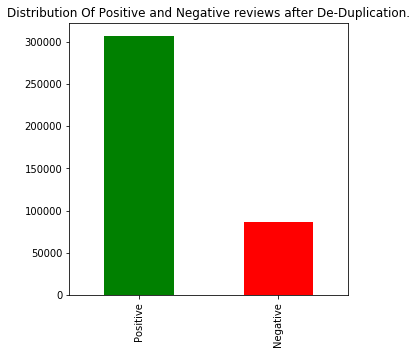

In [52]:
#Dropping unwanted columns for model.
sampled_dataset=final_data.drop(labels=['Id','ProductId', 'UserId', 'Score', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Summary'], axis=1)
print("The shape of the sampled dataset after dropping unwanted columns : ", sampled_dataset.shape)

#Sorting data according to Time in ascending order => Time Based Splitting Step 1.
sampled_dataset=sampled_dataset.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sampled_dataset = sampled_dataset.reset_index()
sampled_dataset=sampled_dataset.drop(labels=['index'], axis=1)

#Display distribution of Postive and Negative reviews in a bar graph
sampled_dataset["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))
sampled_dataset.head(5)

#Display the first 10 rows of the sampled_dataset (All the reviews are arranged according to time)
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

In [53]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc.
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return cleaned_text

#Stemming and stopwords removal
import re
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['not'])
custom_stopwords = default_stopwords - remove_not

#Building a data corpus by removing all stopwords except 'not'. Because 'not' can be an important estimator to differentiate between positive and negative reviews.    
count=0                   #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
data_corpus=[]
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
stemed_word=''
for review in sampled_dataset['Text'].values:
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): #Checking if a word consists of only alphabets + word length is greater than 2.    
                if(cleaned_words.lower() not in custom_stopwords):
                    stemed_word=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(stemed_word)
                    if (sampled_dataset['SentimentPolarity'].values)[count] == 'Positive': 
                        all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
                    if(sampled_dataset['SentimentPolarity'].values)[count] == 'Negative':
                        all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
                else:
                    continue
            else:
                continue 
    string = " ".join(filtered_sentence) #Final string of cleaned words    
    data_corpus.append(string) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
    
print("The length of the data corpus is : {}".format(len(data_corpus)))

The length of the data corpus is : 393931


In [54]:
#Building a data corpus by removing only the Punctuations and HTML tags. Stopwords are preserved. Words are not stemmed. This is useful for Average Word2Vec, TF-IDF W2V.
string=' '    
not_stemmed_corpus=[]
for review in sampled_dataset['Text'].values:
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if(cleaned_words.isalpha()): #Checking if a word consists of only alphabets    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    string = " ".join(filtered_sentence)    
    not_stemmed_corpus.append(string) 
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
sampled_dataset['CleanedText']=data_corpus 

#Adding a column of PreserveStopwords to the table final which stores the data corpus in which stopwords are preserved and words are not stemmed.  
sampled_dataset['PreserveStopwords']=not_stemmed_corpus 

print("Printing the number of positive and negative reviews after data cleaning.")
print(sampled_dataset['SentimentPolarity'].value_counts())

Printing the number of positive and negative reviews after data cleaning.
Positive    307054
Negative     86877
Name: SentimentPolarity, dtype: int64


In [55]:
# Finding most frequently occuring Positive and Negative words 
freq_positive=nltk.FreqDist(all_positive_words)
freq_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_positive.most_common(20))
print("Most Common Negative Words : ",freq_negative.most_common(20))

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

Most Common Positive Words :  [('not', 147653), ('like', 141045), ('tast', 131300), ('good', 113838), ('flavor', 111637), ('love', 107726), ('great', 104572), ('use', 104341), ('one', 97734), ('product', 92278), ('tri', 87155), ('tea', 84870), ('coffe', 79785), ('make', 75417), ('get', 72271), ('food', 65614), ('time', 56218), ('would', 55796), ('buy', 54320), ('realli', 52813)]
Most Common Negative Words :  [('not', 84839), ('tast', 55662), ('like', 53877), ('product', 41117), ('flavor', 36292), ('one', 32078), ('would', 29054), ('good', 28613), ('tri', 27443), ('use', 25931), ('coffe', 25255), ('get', 22638), ('buy', 20036), ('tea', 20026), ('food', 19221), ('order', 17998), ('much', 16861), ('make', 16592), ('realli', 16441), ('box', 16081)]

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels,CleanedText,PreserveStopwords
0,1351209600,Nespresso makes GREAT coffee and GREAT machine...,Negative,0,nespresso make great coffe great machin nespre...,nespresso makes great coffee and great machine...
1,1351209600,"I love these ginger candy, tastes like ginger ...",Positive,1,love ginger candi tast like ginger noth ad nat...,i love these ginger candy tastes like ginger n...
2,1351209600,This product is a great alternative to peanut ...,Positive,1,product great altern peanut butter butter like...,this product is a great alternative to peanut ...
3,1351209600,This is the best coffee ever! Wish I could ord...,Positive,1,best coffe ever wish could order box time thru...,this is the best coffee ever wish i could orde...
4,1351209600,You can taste the butter. The peanuts are fre...,Positive,1,tast butter peanut fresh piec see peanut britt...,you can taste the butter the peanuts are fresh...
5,1351209600,A co-worker recommended that I try Coconut Oil...,Positive,1,worker recommend tri coconut oil make hair sof...,a co worker recommended that i try coconut oil...
6,1351209600,"I was a little hesitant to try these bars, as ...",Positive,1,littl hesit tri bar usual like chocol breakfas...,i was a little hesitant to try these bars as i...
7,1351209600,"This is basically split peas, lentils and smal...",Negative,0,basic split pea lentil small soup pasta guess ...,this is basically split peas lentils and small...
8,1351209600,My first experience with Maui Coffee was bring...,Positive,1,first experi maui coffe bring back maui souven...,my first experience with maui coffee was bring...
9,1351209600,Makes very good break sticks.. Also can be use...,Positive,1,make good break stick also use pizza crust wif...,makes very good break sticks also can be used ...


In [56]:

def standardize(X_train_vectors, X_test_vectors):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=False)
    scalar.fit(X_train_vectors)
    X_train_vectors = scalar.transform(X_train_vectors)
    X_test_vectors = scalar.transform(X_test_vectors)
    print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
    print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))
    return (X_train_vectors, X_test_vectors)

def top_features(nb_classifier, vectorizer_object):
    '''Get top 50 features displayed from both the negative and the positive review classes.'''
    neg_class_prob_sorted = (-nb_classifier.feature_log_prob_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    pos_class_prob_sorted = (-nb_classifier.feature_log_prob_[1, :]).argsort()
    neg_class_features = np.take(vectorizer_object.get_feature_names(), neg_class_prob_sorted[:50])
    pos_class_features = np.take(vectorizer_object.get_feature_names(), pos_class_prob_sorted[:50])
    print("The top 50 most frequent words from the positive class are :\n")
    print(pos_class_features)
    print("\nThe top 50 most frequent words from the negative class are :\n")
    print(neg_class_features)
    del(neg_class_prob_sorted, pos_class_prob_sorted, neg_class_features, pos_class_features)

def performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse): #MSE : Mean Squared Loss
    '''Function to measure the various performance metrics for a given model.'''
    print("\n'''PERFORMANCE EVALUATION'''")
    print("\n\nDetailed report for the {} Vectorization.".format(vectorizationType))

    #Predict the labels for the test set.
    y_pred = nb_classifier.predict(X_test)
    
    #Evaluate the accuracy of the model on test set
    test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
    points = accuracy_score(y_test, y_pred, normalize=False)
    print('\nThe number of accurate predictions out of {} data points on unseen data is {}'.format(X_test.shape[0], points))
    print('Accuracy of the {} model on unseen data is {} %'.format(vectorizationType, np.round(test_accuracy,2)))
    
    #Get the precision, recall and F1 score for this model.
    print("Precision of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.precision_score(y_test ,y_pred),4)))
    print("Recall of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.recall_score(y_test ,y_pred),4)))
    print("F1 score of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.f1_score(y_test ,y_pred),4)))
    
    #Classification Report
    print ('\nClasification report for {} model : \n'.format(vectorizationType))
    print(metrics.classification_report(y_test,y_pred))
    
    #Print the Conclusions on the trained dataset
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp+fn #p = total number of actual postives
    n = fp+tn #p = total number of actual negatives
    TPR = tp/p ; TNR = tn/n ; FPR = fp/n ; FNR = fn/p
    print("\nThe True Positives Rate is : {}".format(TPR))
    print("The True Negatives Rate is : {}".format(TNR))
    print("The False Positives Rate is : {}".format(FPR))
    print("The False Negatives Rate is : {}".format(FNR))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(y_test ,y_pred)*100,2)))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(y_test ,y_pred)*100,2)))
      
    #Save the below list for later use to display model information
    info_model_NB = [vectorizationType, optimal_alpha, np.round(np.array(mse).mean(),4), np.round(1-metrics.accuracy_score(y_test, y_pred),4), np.round(metrics.f1_score(y_test ,y_pred),4), points]
    with open('info_model_NB.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_NB)
        filehandle.writelines("\n")
        
    #Get the confusion matrix for the running model
   # print("\nFind below the confusion matrix for {} model.".format(vectorizationType))
   # plot_confusion_matrix(y_test,y_pred)   
    
    #Free memory allocations
    del(X_train, y_train, X_test, y_test, vectorizationType, y_pred, nb_classifier)
       
def get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    from sklearn.model_selection import TimeSeriesSplit
    alphas = np.logspace(-5, 4, 100)
    tuned_parameters = [{'alpha': alphas}]
    n_folds = 10
    model = MultinomialNB()
    my_cv = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=my_cv, scoring='f1', n_jobs=6)
    gsearch_cv.fit(X_train, y_train)
    print("\nGridSearchCV completed for {} model!".format(vectorizationType))
    print("Best estimator for {} model : ".format(vectorizationType), gsearch_cv.best_estimator_)
    print("Best Score for {} model : ".format(vectorizationType), gsearch_cv.best_score_)
    return gsearch_cv
    
def plot_errors(gsearch_cv):
    '''This function is used to plot the curve for mean squared errors vs alpha values'''
    #Get cross validation scores. Here we obtain the alpha values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    mts = cv_result["mean_test_score"]        #list that will hold the mean of cross validation accuracy scores for each alpha
    alphas = cv_result["params"]

    alpha_values = []                         #list that will hold all the alpha values that the grid search cross validator tried.
    for i in range(0,len(alphas)):
        alpha_values.append(alphas[i]["alpha"])

    #Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    mse = [1 - x for x in mts]

    #Determining best alpha from errors. 'alpha' will be best for the lowest value for error
    optimal_alpha = alpha_values[mse.index(min(mse))] #Laplace smoothing
    print('The optimal value of alpha is : {}'.format(optimal_alpha))     

    #Plot error vs alpha values
    plt.figure(figsize=(35,8))
    plt.plot(alpha_values , mse, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
    for xy in zip(alpha_values, np.round(mse,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('Plot for Errors vs Alpha Values')
    plt.xlabel('Values of Alpha')
    plt.ylabel('Errors')
    plt.show()
    
    return (optimal_alpha,mse)
    
def naive_bayes_algorithm(X_train, y_train, X_test, y_test, vectorizationType, vectorizer_object):
    '''This function splits the dataset into training set and test sets. The test data remains untouched.
    A time series 10 fold cross validation is performed on the train data and the value of optimal alpha is calculated. 
    The dataset is then trained with this value of optimal alpha. 
    Finally the Naive Bayes model is used to predict its accuracy on the future unseen test set.'''
    
    #Perform 10-fold cross validation on the train set
    print("Starting Cross Validation steps...")
    gsearch_cv = get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test)
    
    #Plot the graphical representation of the mean squared error vs the alpha values obtained during cross validation.
    optimal_alpha, mse = plot_errors(gsearch_cv)

    #Initialize the Naive Bayes constructor using alpha = optimal_alpha
    nb_classifier = gsearch_cv.best_estimator_

    #Fit the model to the train set using optimal alpha
    nb_classifier.fit(X_train, y_train)
    
    #Display the top features of both the negative and positive reviews
    top_features(nb_classifier, vectorizer_object)
    
    #Evaluate the model's performance
    performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse)


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (315144, 66576)
The shape of the X_test_vectors is : (78787, 66576)
Starting Cross Validation steps...

GridSearchCV completed for Bag-of-Words model!
Best estimator for Bag-of-Words model :  MultinomialNB(alpha=10000.0, class_prior=None, fit_prior=True)
Best Score for Bag-of-Words model :  0.8675548472396659
The optimal value of alpha is : 10000.0


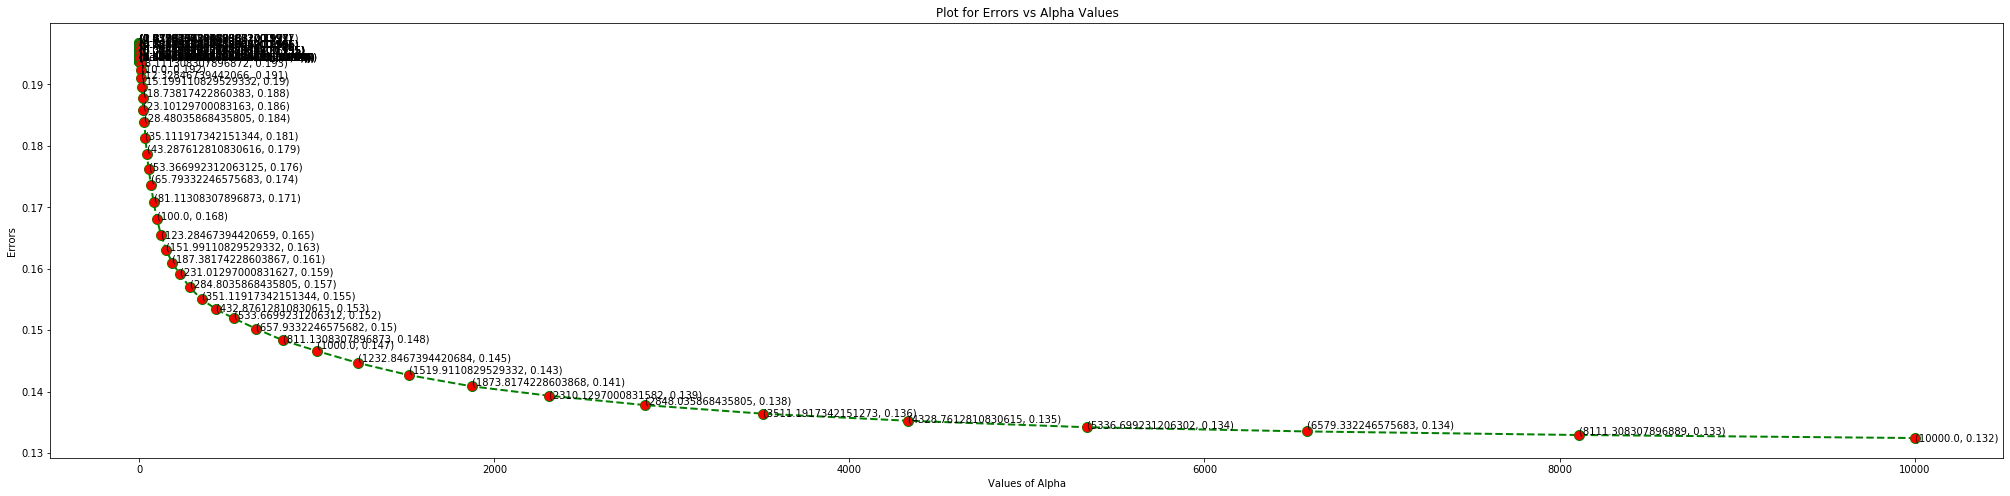

The top 50 most frequent words from the positive class are :

['love' 'great' 'good' 'like' 'tast' 'not' 'tri' 'one' 'use' 'make'
 'flavor' 'get' 'product' 'best' 'time' 'buy' 'find' 'realli' 'also'
 'price' 'much' 'store' 'littl' 'well' 'recommend' 'amazon' 'would' 'eat'
 'delici' 'order' 'year' 'even' 'better' 'found' 'high' 'favorit' 'day'
 'perfect' 'enjoy' 'nice' 'give' 'keep' 'need' 'want' 'first' 'work' 'way'
 'sinc' 'alway' 'sweet']

The top 50 most frequent words from the negative class are :

['not' 'tast' 'like' 'product' 'would' 'disappoint' 'one' 'tri' 'flavor'
 'buy' 'good' 'bad' 'get' 'even' 'much' 'look' 'order' 'thought' 'review'
 'think' 'realli' 'use' 'bought' 'howev' 'better' 'money' 'purchas'
 'packag' 'time' 'first' 'someth' 'want' 'could' 'say' 'box' 'receiv'
 'return' 'know' 'expect' 'got' 'make' 'wast' 'mayb' 'amazon' 'hope'
 'still' 'eat' 'give' 'way' 'open']

'''PERFORMANCE EVALUATION'''


Detailed report for the Bag-of-Words Vectorization.

The number of acc

In [36]:
#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the BOW constructor
cv_object = CountVectorizer().fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

#Colum Standardization of the Bag of Words vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations. 
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bag-of-Words", cv_object)


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (315144, 66576)
The shape of the X_test_vectors is : (78787, 66576)
Starting Cross Validation steps...

GridSearchCV completed for TF-IDF model!
Best estimator for TF-IDF model :  MultinomialNB(alpha=10000.0, class_prior=None, fit_prior=True)
Best Score for TF-IDF model :  0.8686892380766633
The optimal value of alpha is : 10000.0


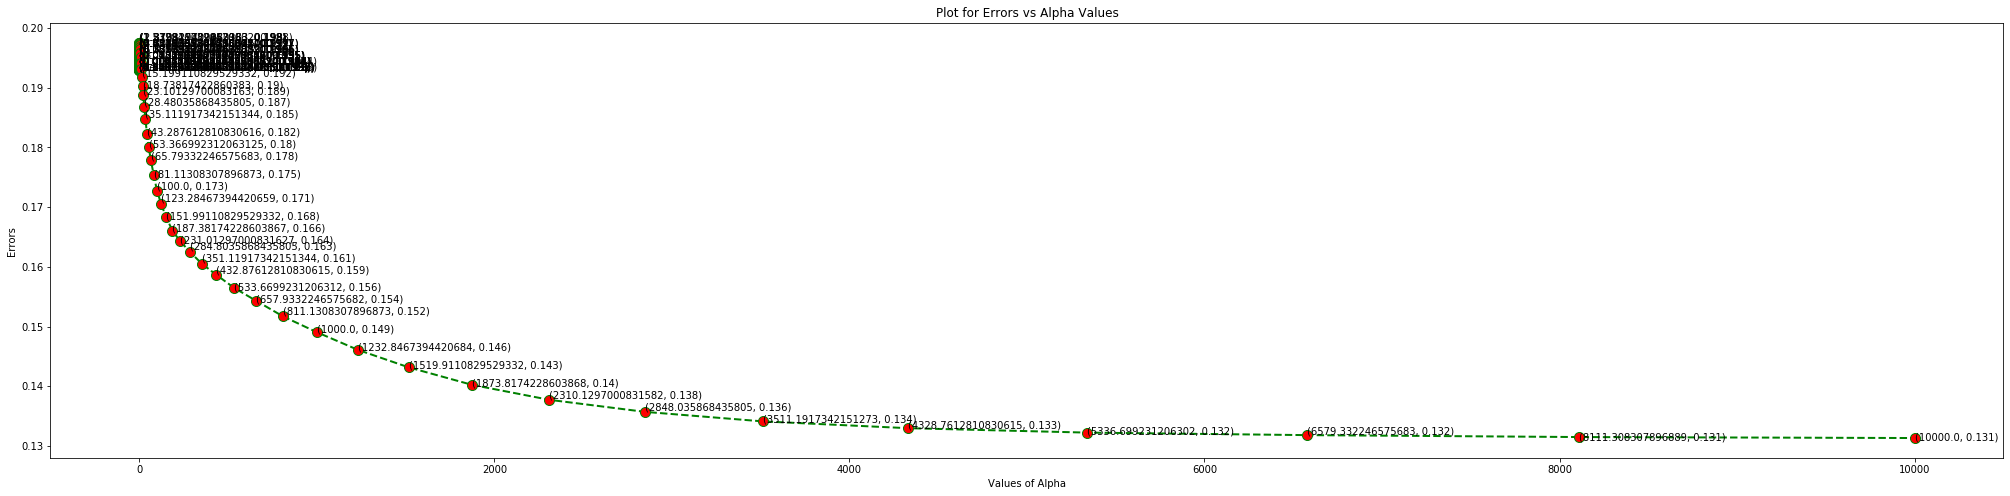

The top 50 most frequent words from the positive class are :

['love' 'great' 'like' 'good' 'tast' 'not' 'use' 'flavor' 'one' 'tri'
 'make' 'product' 'get' 'time' 'best' 'buy' 'find' 'amazon' 'price' 'also'
 'realli' 'well' 'would' 'store' 'littl' 'much' 'eat' 'recommend' 'order'
 'coffe' 'food' 'delici' 'year' 'day' 'even' 'better' 'high' 'found'
 'favorit' 'tea' 'perfect' 'enjoy' 'nice' 'drink' 'give' 'sweet' 'first'
 'work' 'need' 'mix']

The top 50 most frequent words from the negative class are :

['not' 'tast' 'like' 'would' 'product' 'disappoint' 'one' 'flavor' 'tri'
 'bad' 'get' 'buy' 'good' 'review' 'even' 'thought' 'box' 'much' 'look'
 'think' 'order' 'use' 'howev' 'packag' 'return' 'money' 'realli' 'wast'
 'someth' 'first' 'bought' 'better' 'want' 'mayb' 'say' 'could' 'purchas'
 'receiv' 'open' 'know' 'time' 'expect' 'ingredi' 'eat' 'bag' 'coffe'
 'away' 'got' 'hope' 'smell']

'''PERFORMANCE EVALUATION'''


Detailed report for the TF-IDF Vectorization.

The number of accurat

In [44]:
X = sampled_dataset['CleanedText'] 
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = tf_idf_object.transform(X_train)
X_test_vectors = tf_idf_object.transform(X_test)

#Colum Standardization of the TF-IDF vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "TF-IDF", tf_idf_object)



Creating the BOW vectors using PreserveStopwords corpus
The shape of the X_train_vectors is : (315144, 2645813)
The shape of the X_test_vectors is : (78787, 2645813)
Starting Cross Validation steps...

GridSearchCV completed for Bi-Grams model!
Best estimator for Bi-Grams model :  MultinomialNB(alpha=2310.1297000831582, class_prior=None, fit_prior=True)
Best Score for Bi-Grams model :  0.8809326869301994
The optimal value of alpha is : 2310.1297000831582


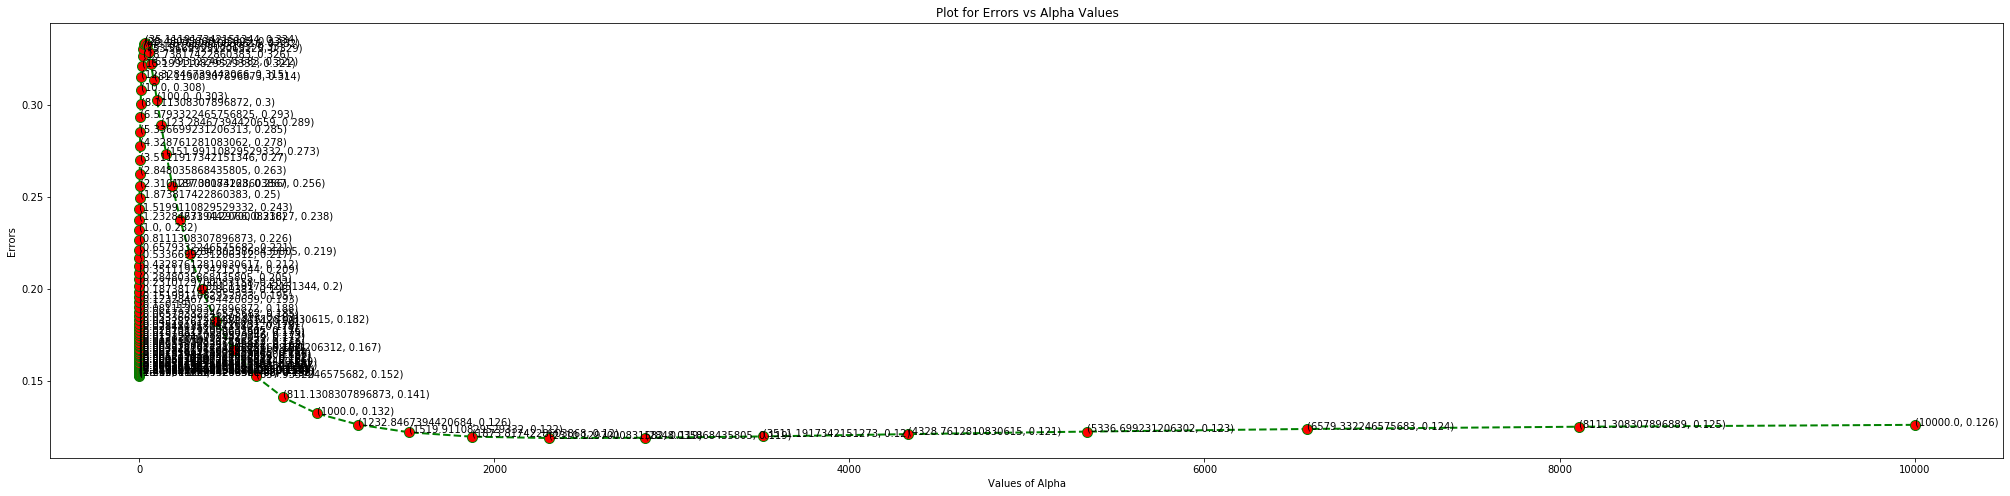

The top 50 most frequent words from the positive class are :

['and' 'the' 'to' 'this' 'it' 'is' 'of' 'for' 'in' 'my' 'with' 'have'
 'but' 'that' 'on' 'so' 'you' 'are' 'great' 'good' 'as' 'not' 'they'
 'like' 'these' 'can' 'was' 'at' 'or' 'just' 'love' 'very' 'be' 'one'
 'this is' 'them' 'all' 'if' 'when' 'taste' 'has' 'will' 'more' 'from'
 'in the' 'flavor' 'it is' 'product' 'of the' 'than']

The top 50 most frequent words from the negative class are :

['the' 'and' 'to' 'not' 'this' 'of' 'it' 'but' 'is' 'was' 'that' 'in'
 'for' 'like' 'be' 'my' 'with' 'have' 'taste' 'would' 'if' 'on' 'had'
 'of the' 'they' 'product' 'so' 'just' 'as' 'you' 'from' 'at' 'all' 'are'
 'one' 'what' 'were' 'there' 'out' 'bad' 'don' 'or' 'flavor' 'me' 'in the'
 'it was' 'when' 'these' 'no' 'very']

'''PERFORMANCE EVALUATION'''


Detailed report for the Bi-Grams Vectorization.

The number of accurate predictions out of 78787 data points on unseen data is 66916
Accuracy of the Bi-Grams model on unseen data is 

In [51]:
X = sampled_dataset['PreserveStopwords']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
bigrams_object = TfidfVectorizer(ngram_range=(1,2)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using PreserveStopwords corpus")
X_train_vectors = bigrams_object.transform(X_train)
X_test_vectors = bigrams_object.transform(X_test)

#Colum Standardization of the T-gram vector created using preserved stopwords data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bi-Grams", bigrams_object)


Creating the BOW vectors using PreserveStopwords corpus
The shape of the X_train_vectors is : (315144, 12476112)
The shape of the X_test_vectors is : (78787, 12476112)
Starting Cross Validation steps...

GridSearchCV completed for Tri-Grams model!
Best estimator for Tri-Grams model :  MultinomialNB(alpha=1e-05, class_prior=None, fit_prior=True)
Best Score for Tri-Grams model :  0.8703215914754654
The optimal value of alpha is : 1e-05


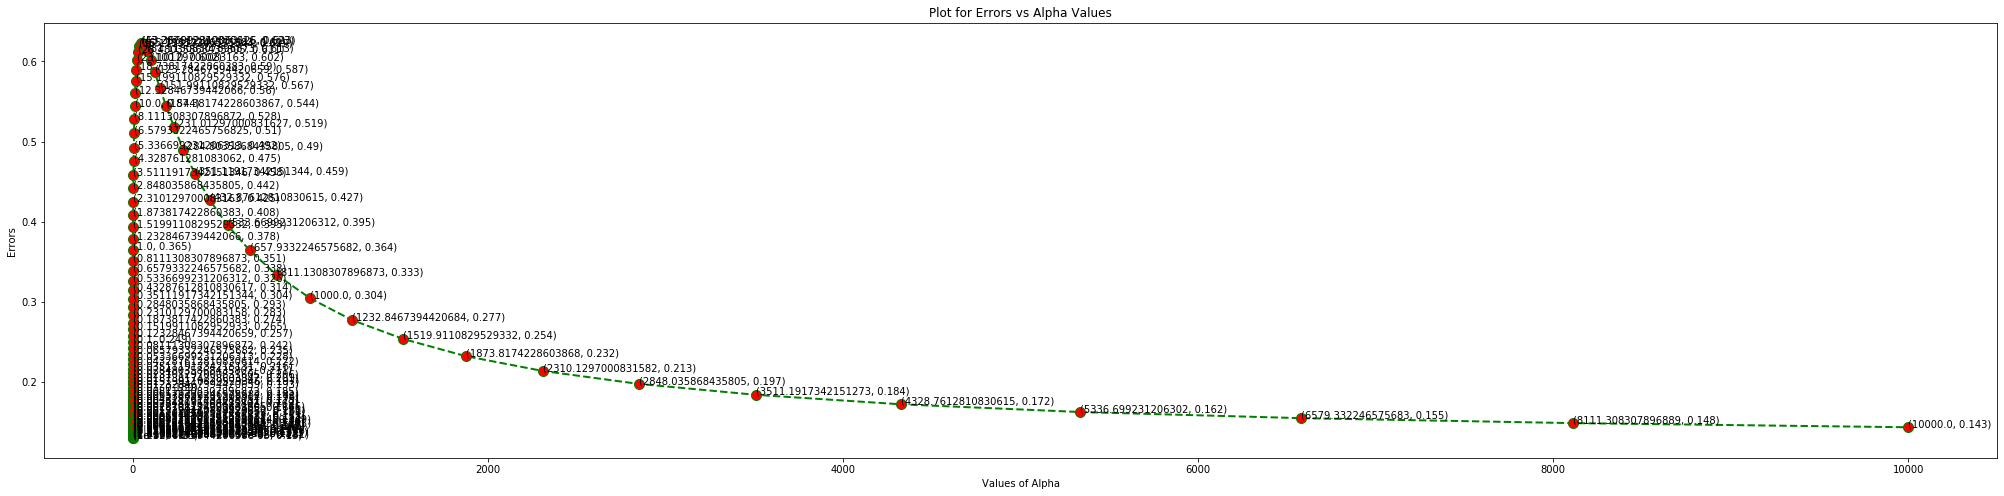

The top 50 most frequent words from the positive class are :

['this is' 'in the' 'it is' 'of the' 'the best' 'if you' 'and the'
 'is the' 'they are' 'and it' 'on the' 'this product' 'for the' 'to the'
 'to be' 'in my' 'with the' 'you can' 'is great' 'it was' 'to find'
 'these are' 'have to' 'one of' 'the price' 'for my' 'and they' 'to make'
 'love this' 'it in' 'it has' 'to get' 'this is the' 'but it' 'is very'
 'all the' 'at the' 'of this' 'the only' 'have been' 'my favorite'
 'on amazon' 'the taste' 'like the' 'as well' 'easy to' 'and have'
 'that it' 'it and' 'and this']

The top 50 most frequent words from the negative class are :

['of the' 'in the' 'it was' 'to be' 'on the' 'is not' 'this product'
 'if you' 'at all' 'did not' 'to the' 'it is' 'but the' 'the same'
 'would not' 'the product' 'but it' 'would be' 'and the' 'the taste'
 'for the' 'will not' 'do not' 'was not' 'not buy' 'very disappointed'
 'this is' 'with the' 'that the' 'of this' 'the box' 'the worst' 'not the'
 'th

In [57]:
#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['PreserveStopwords']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
tri_grams_object = TfidfVectorizer(ngram_range=(2,3)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using PreserveStopwords corpus")
X_train_vectors = tri_grams_object.transform(X_train)
X_test_vectors = tri_grams_object.transform(X_test)

#Colum Standardization of the tri-gram vector created using preserved stopwords data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Tri-Grams", tri_grams_object)

In [1]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", " Hyper-Parameter Value (alpha=)", "Train Error", "Test Error", "F1-Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_NB.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
|    Model     |  Hyper-Parameter Value (alpha=) | Train Error | Test Error | F1-Score | No. Of accurate predictions |
+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
| Bag-of-Words |             10000.0             |    0.1827   |   0.1753   |  0.9034  |            64975            |
| Bag-of-Words |             10000.0             |    0.1827   |   0.1753   |  0.9034  |            64975            |
| Bag-of-Words |             10000.0             |    0.1827   |   0.1753   |  0.9034  |            64975            |
|    TF-IDF    |             10000.0             |    0.1834   |   0.1767   |  0.9024  |            64862            |
|   Bi-Grams   |        2310.1297000831582       |    0.1985   |   0.1507   |  0.9148  |            